In [7]:
import numpy as np
import glob
import h5py

import matplotlib
matplotlib.use("Agg")

import matplotlib.pyplot as plt
%matplotlib inline

import gwpy
from gwpy import segments
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import StateVector
import gwpy.astro

import json

from scipy.interpolate import interp1d
from astropy import cosmology, units as u
from pycbc.frame import StatusBuffer
from pycbc.frame import read_frame
from pycbc.filter import matched_filter, highpass, lowpass, sigma, resample_to_delta_t
from pycbc.psd import interpolate, inverse_spectrum_truncation, welch
from pycbc.types.frequencyseries import FrequencySeries

from pycbc.waveform import get_td_waveform, TemplateBank
from pycbc.detector import Detector
from pycbc.psd import interpolate

from tqdm import tqdm
# import ligo.skymap.plot

/home/chiajui.chou/miniforge3/envs/igwn-py310/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/home/chiajui.chou/miniforge3/envs/igwn-py310/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


### Check state vector and load data

(1420878061, 1420878149, 88)


Strain Data of H1 in the segment (1420878061, 1420878149, 88) is loaded.
(1420878061, 1420878149, 88)
Strain Data of L1 in the segment (1420878061, 1420878149, 88) is loaded.


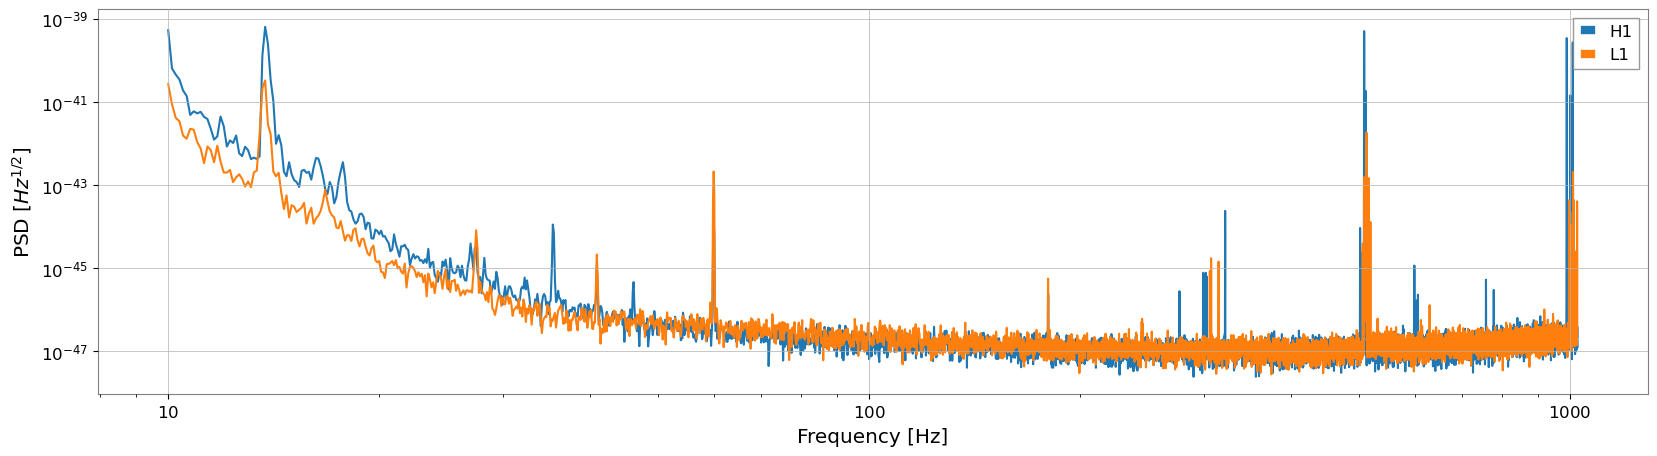

In [8]:
# Config
ifos = ["H1", "L1"]
ts_dict = dict.fromkeys(ifos)
psd_dict = dict.fromkeys(ifos)
for ifo in ifos:
    channels = [
        f"{ifo}:GDS-CALIB_STATE_VECTOR_AR",
        f"{ifo}:GDS-CALIB_STRAIN_CLEAN_AR",
    ]
    # trigger_time = 1384782888.7
    # time_label = 138
    trigger_time = 1420878141.22
    time_label = 142
    psd_length = 64
    before_trigger_length = psd_length + 16
    after_trigger_length = 8
    full_length = before_trigger_length + after_trigger_length
    start = int(trigger_time) - before_trigger_length
    end = int(trigger_time) + after_trigger_length
    duration = end - start
    print((start, end, duration))
    data_dir = f"/archive/frames/O4/hoft_C00_AR/{ifo}/{ifo[0]}-{ifo}_HOFT_C00_AR-{time_label}"
    source = glob.glob(f"{data_dir}/*.gwf")
    fftlength = 8
    overlap = 4
    window_length = 10

    # Check data quality and load data
    sv = StateVector.read(
        source=source,
        channel=channels[0],
        start=start,
        end=end,
    )
    bit_dict = sv.get_bit_series(bits=['Bit 0', 'Bit 1'])
    bit_series_0 = bit_dict['Bit 0']
    bit_series_1 = bit_dict['Bit 1']
    bit_check = (bit_series_0 * bit_series_1).all()
    if bit_check == True:
        gwpy_ts = TimeSeries.read(
            source=source,
            channel=channels[1],
            start=start,
            end=end,
        )
        ts_dict[ifo] = gwpy_ts.to_pycbc()
        print(f"Strain Data of {ifo} in the segment {(start, end, duration)} is loaded.")
    else:
        raise RuntimeError(f"Data Quality check faild for {ifo} data in the segment {(start, end, duration)}.")

    # Calculate PSD
    ts = ts_dict[ifo]
    psd_ts = ts.crop(0,full_length-psd_length)
    psd = psd_ts.psd(fftlength)
    psd_dict[ifo] = psd

flow, fhigh = 10, 1024
fst, fed = int(flow/psd.delta_f), int(fhigh/psd.delta_f)
plt.figure(figsize=[20,5])
for ifo in ifos:
    plt.plot(psd_dict[ifo].sample_frequencies[fst:fed], psd_dict[ifo][fst:fed], label=ifo)

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"PSD [$Hz^{1/2}$]")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

### Template

In [9]:
# parameter_dict = {
#     "approximant": "SEOBNRv4_ROM",
#     "mass1": 222.21446,
#     "mass2": 95.70826,
#     "spin1x": 0.0,
#     "spin1y": 0.0,
#     "spin1z": 0.0,
#     "spin2x": 0.0,
#     "spin2y": 0.0,
#     "spin2z": 0.0,
#     "sample_rate": 4096,
#     "f_lower": 10,
# }
parameter_dict = {
    "approximant": "SEOBNRv4_ROM",
    "mass1": 36.918,
    "mass2": 34.913,
    "spin1x": 0.0,
    "spin1y": 0.0,
    "spin1z": -0.012,
    "spin2x": 0.0,
    "spin2y": 0.0,
    "spin2z": -0.028,
    "sample_rate": 4096,
    "f_lower": 10,
}


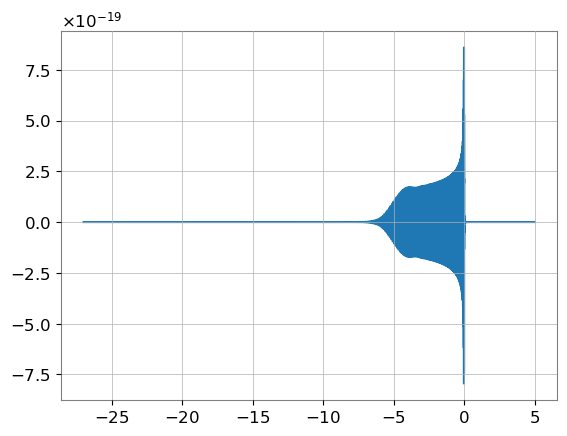

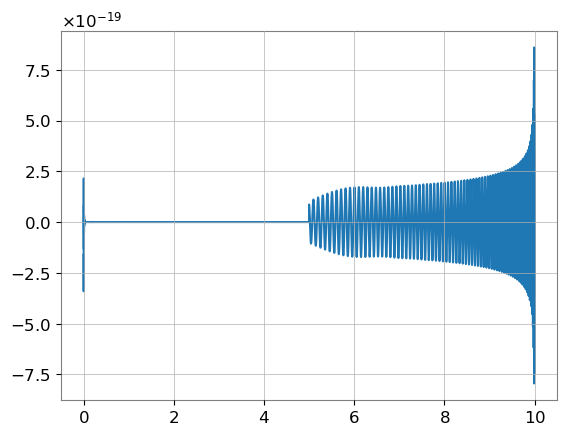

In [10]:
hp, hc = get_td_waveform(
    approximant=parameter_dict["approximant"],
    mass1=parameter_dict["mass1"],
    mass2=parameter_dict["mass2"],
    spin1x=parameter_dict["spin1x"],
    spin1y=parameter_dict["spin1y"],
    spin1z=parameter_dict["spin1z"],
    spin2x=parameter_dict["spin2x"],
    spin2y=parameter_dict["spin2y"],
    spin2z=parameter_dict["spin2z"],
    delta_t=1/parameter_dict["sample_rate"],
    f_lower=parameter_dict["f_lower"],
)
plt.plot(hp.sample_times, hp)
plt.show()

# Cropping template to window_length
sample_rate = parameter_dict["sample_rate"]
ini_template_ts = hp.copy()
st = ini_template_ts.sample_times[0]
ed = ini_template_ts.sample_times[-1]
if np.abs(st) < window_length/2:
    pad_num = int((window_length/2 - np.abs(st))*sample_rate)
    ini_template_ts.prepend_zeros(pad_num)
if np.abs(ed) < window_length/2:
    pad_num = int((window_length/2 - np.abs(ed))*sample_rate)
    ini_template_ts.append_zeros(pad_num)

st_crop = -window_length/2 - ini_template_ts.sample_times[0]
ed_crop = ini_template_ts.sample_times[-1] + 1/sample_rate - window_length/2
template_ts = ini_template_ts.crop(st_crop, ed_crop)
shifted_template_ts = template_ts.cyclic_time_shift(template_ts.start_time)
plt.plot(shifted_template_ts.sample_times, shifted_template_ts)
plt.show()

### Matched Filtering using PyCBC

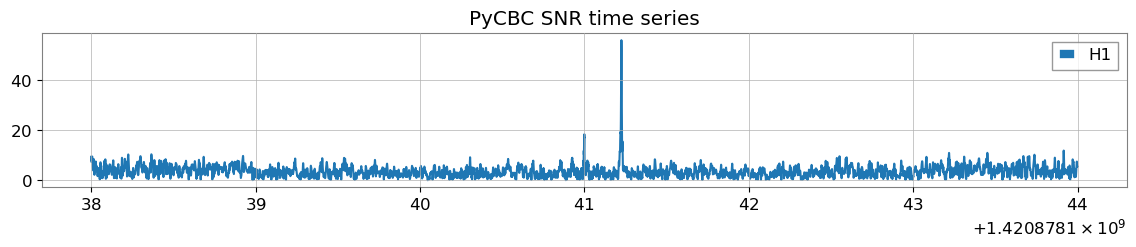

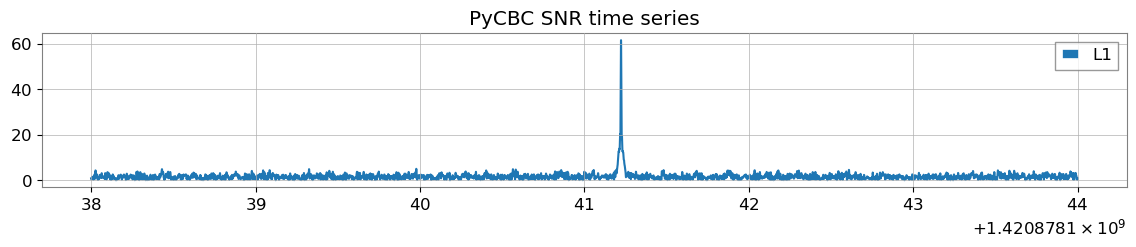

In [11]:
ifos = ["H1", "L1"]
sample_rate = parameter_dict["sample_rate"]
fmin = 10
low_frequency_cutoff = 10
snr_crop_length = 2
snr_dict = dict.fromkeys(ifos)
for ifo in ifos:
    # data conditioning
    data_ts = ts_dict[ifo].crop(full_length-2*after_trigger_length,0)
    data_ts = highpass(data_ts, fmin)
    data_ts = data_ts.resample(1/sample_rate)
    data_crop_length = (data_ts.duration - window_length)/2
    data_ts = data_ts.crop(data_crop_length, data_crop_length)
    psd = interpolate(psd_dict[ifo], data_ts.delta_f)

    # matched filtering
    snr_ts = matched_filter(
        shifted_template_ts,
        data_ts,
        psd=psd,
        low_frequency_cutoff=low_frequency_cutoff,
    )
    snr_dict[ifo] = snr_ts.crop(snr_crop_length, snr_crop_length)

    plt.figure(figsize=[14,2])
    plt.title("PyCBC SNR time series")
    plt.plot(snr_dict[ifo].sample_times, np.abs(snr_dict[ifo]), label=ifo)
    # plt.axvline(gps_time, color='r')
    plt.legend()
    plt.show()


### Loding seqARIMA's PSD

In [12]:
def read_psd(filename, delimiter=" "):
    data = np.loadtxt(filename, delimiter=delimiter)
    freqs = data[:,0]
    value = data[:,1]
    fs = FrequencySeries(value, delta_f=freqs[1])

    return fs

In [13]:
# psd_dir = "/home/chihyi.chang/data/beacon_data"
psd_dir = "/home/chiajui.chou/beacon_data"
ifos = ["H1", "L1"]
psd_ids = ["p4k", "p8k", "p8k_q3"]
psd_collection = dict.fromkeys(psd_ids)

for psd_id in psd_collection.keys():
    psd_collection[psd_id] = dict.fromkeys(ifos)
    for ifo in ifos:
        psd_collection[psd_id][ifo] = read_psd(f"{psd_dir}/PSD_{ifo}_{psd_id}.dat")

# Plotting PSD
#     for ifo  in ifos:
#         plt.title(f"PSD_{psd_id}")
#         plt.plot(psd_collection[psd_id][ifo].sample_frequencies, psd_collection[psd_id][ifo], label=ifo, alpha=0.5)
#         plt.xlim(10, 1024)
#         plt.ylim(1e-48, 1e-30)
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.xlabel('Frequency [Hz]')
#         plt.ylabel('PSD[1/Hz]')
#         plt.legend()

#     plt.show()

### Matched Filtering using seqARIMA's PSD

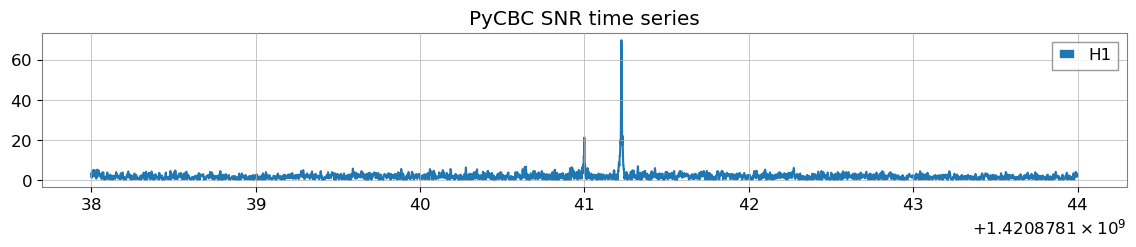

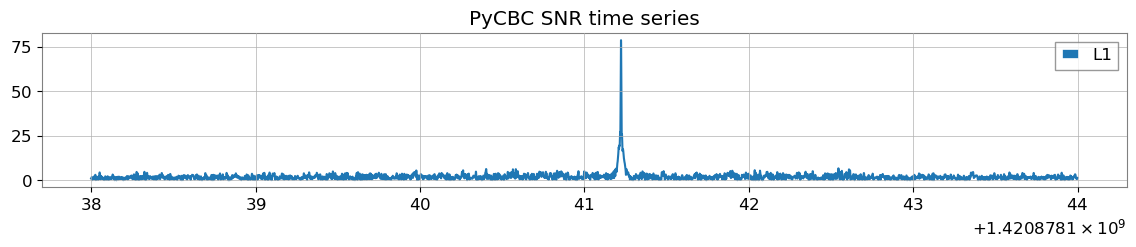

In [14]:
psd_dir = "/home/chiajui.chou/beacon_data"
ifos = ["H1", "L1"]
psd_ids = ["p4k", "p8k", "p8k_q3"]
fmin = 10
low_frequency_cutoff = 10
snr_crop_length = 2
sample_rate = parameter_dict["sample_rate"]

# Loading PSD
psd_collection = dict.fromkeys(psd_ids)
for psd_id in psd_collection.keys():
    psd_collection[psd_id] = dict.fromkeys(ifos)
    for ifo in ifos:
        psd_collection[psd_id][ifo] = read_psd(f"{psd_dir}/PSD_{ifo}_{psd_id}.dat")

# Matched Filtering
seqarima_snr_dict = dict.fromkeys(ifos)
psd_dict = psd_collection["p8k_q3"]
for ifo in ifos:
    # data conditioning
    data_ts = ts_dict[ifo].crop(full_length-2*after_trigger_length,0)
    data_ts = highpass(data_ts, fmin)
    data_ts = data_ts.resample(1/sample_rate)
    data_crop_length = (data_ts.duration - window_length)/2
    data_ts = data_ts.crop(data_crop_length, data_crop_length)
    psd = interpolate(psd_dict[ifo], data_ts.delta_f)

    # matched filtering
    snr_ts = matched_filter(
        shifted_template_ts,
        data_ts,
        psd=psd,
        low_frequency_cutoff=low_frequency_cutoff,
    )
    seqarima_snr_dict[ifo] = snr_ts.crop(snr_crop_length, snr_crop_length)

    plt.figure(figsize=[14,2])
    plt.title("PyCBC SNR time series")
    plt.plot(seqarima_snr_dict[ifo].sample_times, np.abs(seqarima_snr_dict[ifo]), label=ifo)
    # plt.axvline(gps_time, color='r')
    plt.legend()
    plt.show()


### Compare the results between seqARIMA and original matched filtering.

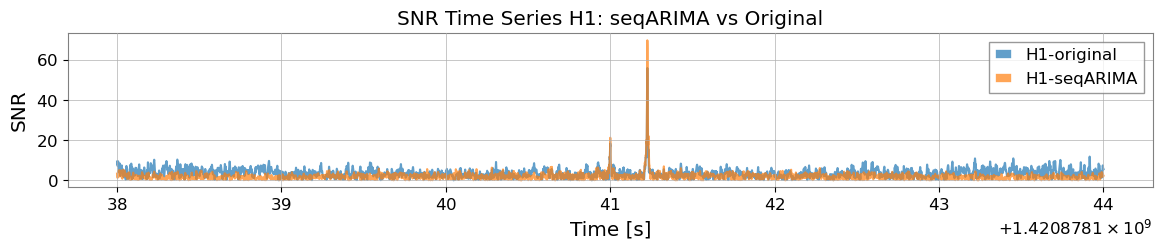

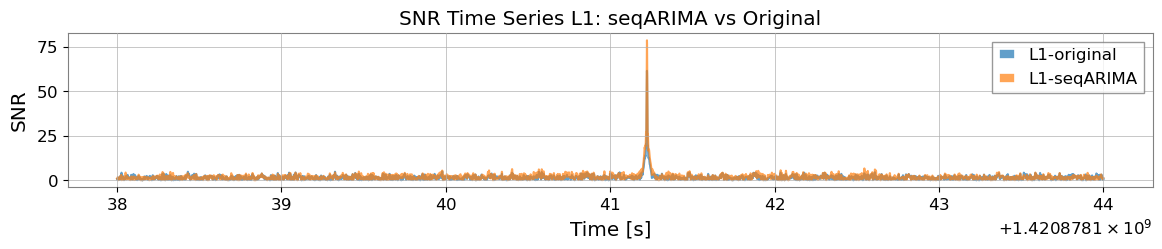

In [15]:
for ifo in ifos:
    plt.figure(figsize=[14,2])
    plt.title(f"SNR Time Series {ifo}: seqARIMA vs Original")
    plt.plot(snr_dict[ifo].sample_times, np.abs(snr_dict[ifo]), label=f"{ifo}-original", alpha=0.7)
    plt.plot(seqarima_snr_dict[ifo].sample_times, np.abs(seqarima_snr_dict[ifo]), label=f"{ifo}-seqARIMA", alpha=0.7)
    plt.xlabel("Time [s]")
    plt.ylabel("SNR")
    plt.legend()
    plt.show()

### Save SNR Time Series and PSD

In [16]:
def crop_snr_ts(
    snr_ts_dict: dict,
    trigger_time: float,
    time_before_trigger: float=1,
    time_after_trigger: float=1,
    res_time_before_trigger:float=0.1,
    res_time_after_trigger:float=0.1,
):
    ifos = snr_ts_dict.keys()
    trigger_time_dict = dict.fromkeys(ifos)
    cropped_snr_ts_dict = dict.fromkeys(ifos)
    for ifo in ifos:
        trigger_index = int(np.argmin(np.abs(snr_ts_dict[ifo].sample_times - trigger_time)))
        sample_rate = snr_ts_dict[ifo].sample_rate

        # Crop the SNR time series that put the trigger_time at the center.
        st = trigger_index - int(time_before_trigger*sample_rate)
        ed = trigger_index + int(time_after_trigger*sample_rate)
        res_snr_ts = snr_ts_dict[ifo][st:ed]
        # Find the time of the largest SNR.
        max_index = np.argmax(np.abs(res_snr_ts))
        trigger_time_dict[ifo] = res_snr_ts.sample_times[max_index]
        # Shift the trigger time to the very center.
        st = max_index - int(res_time_before_trigger*sample_rate) - 1
        ed = max_index + int(res_time_after_trigger*sample_rate)
        cropped_snr_ts_dict[ifo] = res_snr_ts[st:ed]

    return cropped_snr_ts_dict, trigger_time_dict,

def write_snr(
    output_file: str,
    psd_dict: dict,
    parameter_dict: dict,
    snr_ts_dict: dict,
    trigger_time_dict: dict,
):
    with h5py.File(output_file, 'w') as f:
        event = f.create_group("event")
        Parameters = event.create_group("Parameters")
        SNR_ts = event.create_group("SNR_ts")
        PSD = event.create_group("PSD")

        Parameters.create_dataset("Mass1", data=parameter_dict["mass1"])
        Parameters.create_dataset("Mass2", data=parameter_dict["mass2"])
        Parameters.create_dataset("Spin1x", data=parameter_dict["spin1x"])
        Parameters.create_dataset("Spin1y", data=parameter_dict["spin1y"])
        Parameters.create_dataset("Spin1z", data=parameter_dict["spin1z"])
        Parameters.create_dataset("Spin2x", data=parameter_dict["spin2x"])
        Parameters.create_dataset("Spin2y", data=parameter_dict["spin2y"])
        Parameters.create_dataset("Spin2z", data=parameter_dict["spin2z"])

        ifos = snr_ts_dict.keys()
        for ifo in ifos:
            SNR_ts.create_dataset(f"{ifo}-SNR_ts", data=snr_ts_dict[ifo])
            SNR_ts.create_dataset(f"{ifo}-start_time", data=snr_ts_dict[ifo].sample_times[0])
            SNR_ts.create_dataset(f"{ifo}-trigger_time", data=trigger_time_dict[ifo])
            SNR_ts.create_dataset(f"{ifo}-sampling_rate", data=snr_ts_dict[ifo].sample_rate)
            PSD.create_dataset(f"{ifo}-PSD", data=psd_dict[ifo])
            PSD.create_dataset(f"{ifo}-start_time", data=snr_ts_dict[ifo].sample_times[0])
            PSD.create_dataset(f"{ifo}-delta_f", data=psd_dict[ifo].delta_f)
            PSD.create_dataset(f"{ifo}-f0", data=psd_dict[ifo].sample_frequencies[0])

    return

In [17]:
event_label = "gw250114"
psd_id = "p8k_q3"
output_file = f"/home/chiajui.chou/bayestar-test/coinc_{event_label}_{psd_id}.hdf5"
psd_dict = psd_dict
parameter_dict = parameter_dict
snr_ts_dict = snr_dict

cropped_snr_ts_dict, trigger_time_dict = crop_snr_ts(
    snr_ts_dict=snr_ts_dict,
    trigger_time=trigger_time,
)

write_snr(
    output_file=output_file,
    psd_dict=psd_dict,
    parameter_dict=parameter_dict,
    snr_ts_dict=cropped_snr_ts_dict,
    trigger_time_dict=trigger_time_dict,
)

### Running Bayestar

In [ ]:
# import os

# # Use bayestar to calculate the skymap.
# coinc_xml = "/home/chiajui.chou/bayestar-test/coinc_gw250114_p8k_q3.xml"
# os.system(f"bayestar-localize-coincs {coinc_xml} {coinc_xml}")

# # Plot the skymap.
# event_id = 0
# output_file = "output.png"
# os.system(f"ligo-skymap-plot {event_id}.fits -o {output_file}")

### Download Raw Data

In [ ]:
def parse_data_source(
    ifo: str,
    data_dir: str,
    start: float,
    end: float,
):

    return

def check_statevector(
    source_dict: dict,
    channel_dict: dict,
    start: float,
    end: float,
    format: str="gwf",
):
    ifos = list(source_dict.keys())
    dq_check_results = dict.fromkeys(ifos)
    for ifo in ifos:
        if source_dict[ifo] is None:
            continue
        else:
            sv = StateVector.read(
                source=source_dict[ifo],
                channel=channel_dict[ifo],
                format=format,
                start=start,
                end=end,
            )
            if ifo == "H1" or "L1":
                bit_dict = sv.get_bit_series(
                    bits=['Bit 0', 'Bit 1']
                )
                bit_series_0 = bit_dict['Bit 0']
                bit_series_1 = bit_dict['Bit 1']
                bit_check = (bit_series_0 * bit_series_1).all()
            if ifo == "V1":
                bit_dict = sv.get_bit_series(
                    bits=['Bit 0', 'Bit 1', 'Bit 10']
                )
                bit_series_0 = bit_dict['Bit 0']
                bit_series_1 = bit_dict['Bit 1']
                bit_series_10 = bit_dict['Bit 10']
                bit_check = (bit_series_0 * bit_series_1 * bit_sereis_10).all()
            if ifo == "K1":
                bit_dict = sv.get_bit_series(
                    bits=['Bit 0']
                )
                bit_series_0 = bit_dict['Bit 0']
                bit_check = (bit_series_0).all()
            dq_check_results[ifo] = bit_check

    return dq_check_results

def get_data(
    source_dict: dict,
    channel_dict: dict,
    start: float,
    end: float,
):
    ifos = list(source_dict.keys())
    ts_dict = dict.fromkeys(ifos)
    for ifo in ifos:
        ts = TimeSeries.read(
            source=source_dict[ifo],
            channel=channel_dict[ifo],
            start=start,
            end=end,
        )
        ts_dict[ifo] = ts

    return ts_dict

In [ ]:
dq_channel_dict = {
    "H1": "H1:GDS-CAL_STATE_VECTOR_AR",
    "L1": "L1:GDS-CAL_STATE_VECTOR_AR",
    "V1": "V1:DQ_ANALYSIS_STATE_VECTOR",
    "K1": "K1:CAL-STATE_VECTOR_C00",
}
strain_channel_dict = {
    "H1": "H1:GDS-CAL_STRAIN_AR",
    "L1": "L1:GDS-CAL_STRAIN_AR",
    "V1": "V1:Hrec_hoftRepro1AR_16384Hz",
    "K1": "K1:GRD-CAL_STRAIN_C00",
}

event_time = 1440584675.73 
start = int(event_time - 10)
end = int(event_time + 10) 
H1_data_dir = "/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144"
H1_source = glob.glob(f"{data_dir}/*.gwf")
H1_source = sorted(H1_source)
L1_data_dir = "/archive/frames/O4/hoft_C00_AR/L1/L-L1_HOFT_C00_AR-144"
L1_source = glob.glob(f"{data_dir}/*.gwf")
L1_source = sorted(L1_source)

source_dict = {
    "H1": H1_source,
    "L1": L1_source,
    "V1": None,
    "K1": None,
}

['/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440002048-4096.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440006144-2913.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440010984-3352.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440014336-4096.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440018432-4096.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440022528-4096.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440026624-4096.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440030720-4096.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440034816-4096.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144/H-H1_HOFT_C00_AR-1440038912-4096.gwf', '/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_